In [1]:
!pip install pytorch_lightning
!pip install pytorch-lifestream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 KB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 KB 

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#Change to your data folder
%cd drive/MyDrive/ML_final_project

/content/drive/MyDrive/ML_final_project


In [4]:
#Creating iterable datasets from .parquet files
from ptls.data_load.datasets import ParquetDataset, ParquetFiles

iterable_train = ParquetDataset(ParquetFiles('train.parquet'))
next(iter(iterable_train))

{'user_id': '108cd73f450a447dbbe258b1d8734cc4',
 'cat_id': tensor([  1,   1,   4, 118,  21,  21,  47,  12,  12,  12,  12,   8,   8,   1,
           1,   8,   1,   1,   3,   4,   4,   3,   1,   3,   1,  14,  13,   6,
           8,   1,  39,   1,   6,  13,  14,   1,  14,   1,   8,   1,   4,  20,
           4,   1,   1,   4,  13,  20,   1,   3,   3,   1,   1,   1,   3,   1,
           1,   1,  44,  48,   8,   8,   3,   8,   8,   4,   4,   4,   3,   4,
           8,   4,   3,  11,   4,   1,   8,   1,   4,   1,   8,   1,   3,   8,
           1,   1,   4,   8,   4,   8,  11,   8,   1,   4,   4,   8,   1,   1,
           4,   8,   4,   1,   1,   8,  77,   1,  77,  11,   8,   8,   1,   8,
           8,   8,   8,   8,   8,   1,   3,   8,   8,   8,   1,   8,  77,   8,
           8,   8,   1,   8,  77,   8,   8,   1,  11,   1,   3,   8,   8,   8,
           8,  11,   1,   3,   1,   3,   1,   1,   9,   3,   9,   1,   1,   8,
           9,   9,   9,   1,   1,   1,   1,   8,   8,  13,   8,  13,   8,

In [5]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter

map_processed_train = MemoryMapDataset(
    data=iterable_train,
    i_filters=[
        SeqLenFilter(min_seq_len=25),
    ],
)

In [6]:
map_processed_train[0]

{'user_id': '108cd73f450a447dbbe258b1d8734cc4',
 'cat_id': tensor([  1,   1,   4, 118,  21,  21,  47,  12,  12,  12,  12,   8,   8,   1,
           1,   8,   1,   1,   3,   4,   4,   3,   1,   3,   1,  14,  13,   6,
           8,   1,  39,   1,   6,  13,  14,   1,  14,   1,   8,   1,   4,  20,
           4,   1,   1,   4,  13,  20,   1,   3,   3,   1,   1,   1,   3,   1,
           1,   1,  44,  48,   8,   8,   3,   8,   8,   4,   4,   4,   3,   4,
           8,   4,   3,  11,   4,   1,   8,   1,   4,   1,   8,   1,   3,   8,
           1,   1,   4,   8,   4,   8,  11,   8,   1,   4,   4,   8,   1,   1,
           4,   8,   4,   1,   1,   8,  77,   1,  77,  11,   8,   8,   1,   8,
           8,   8,   8,   8,   8,   1,   3,   8,   8,   8,   1,   8,  77,   8,
           8,   8,   1,   8,  77,   8,   8,   1,  11,   1,   3,   8,   8,   8,
           8,  11,   1,   3,   1,   3,   1,   1,   9,   3,   9,   1,   1,   8,
           9,   9,   9,   1,   1,   1,   1,   8,   8,  13,   8,  13,   8,

#Creating model

In [7]:
import torch
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={},
    embeddings={
        'event_time': {'in': 800, 'out': 16},
        'cat_id': {'in': 410, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

#Creating dataloaders

In [8]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=ColesDataset(
        map_processed_train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=200,
        ),
    ),
    train_num_workers=2,
    train_batch_size=256,
)

#Training procedure

In [9]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    max_epochs=15,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [10]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


logger.version = 17


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 242 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.969     Total estimated model params size (MB)


{'loss': tensor(193.3969), 'seq_len': tensor(110.1616)}
CPU times: user 3min 23s, sys: 14.3 s, total: 3min 37s
Wall time: 4min 25s


In [11]:
torch.save(seq_encoder.state_dict(), "coles-emb-clickstream.pt")

#Creating embeddings

In [12]:
from ptls.data_load.datasets import inference_data_loader

iterable_test = ParquetDataset(ParquetFiles('test.parquet'))

train_dl = inference_data_loader(list(iter(iterable_train)), num_workers=0, batch_size=256)

train_embeds = torch.vstack(trainer.predict(model, train_dl, ))


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [13]:
train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

test_dl = inference_data_loader(list(iter(iterable_test)), num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([15715, 256]), torch.Size([3908, 256]))

#Creating pandas df-s with embeddings and target

In [14]:
import pandas as pd
df_target = pd.read_csv('target_dataset_matched.csv')
df_target.rename(columns={'rtk':'user_id'},inplace=True)
df_target = df_target.set_index('user_id')
df_target.rename(columns={"higher_education": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['user_id'] = [x['user_id'] for x in iter(iterable_train)]
train_df = train_df.merge(df_target, how='left', on='user_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['user_id'] = [x['user_id'] for x in iter(iterable_test)]
test_df = test_df.merge(df_target, how='left', on='user_id')

print(train_df.shape, test_df.shape)

(15715, 258) (3908, 258)


In [15]:
train_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_248,embed_249,embed_250,embed_251,embed_252,embed_253,embed_254,embed_255,user_id,target
0,0.945030,-0.909957,-0.111413,0.036585,-0.970117,0.958681,-0.915938,0.295091,0.972059,-0.894210,...,-0.594910,0.085594,0.213679,0.296339,-0.616856,0.566167,-0.687932,-0.105907,108cd73f450a447dbbe258b1d8734cc4,NaN
1,0.784063,-0.860334,0.069231,-0.187402,-0.809402,0.919175,-0.835526,0.229140,0.708987,-0.856140,...,-0.713246,-0.301625,-0.110672,0.573828,-0.685807,-0.146865,-0.745148,-0.007760,4a458595d55147ebabcd903e8b01be28,NaN
2,0.958949,-0.937442,0.137474,-0.157008,-0.978078,0.973725,-0.936216,0.035976,0.967344,-0.956104,...,-0.713659,-0.377481,0.219518,0.043661,-0.478464,0.081142,-0.595418,-0.352522,56d7a84eb64c4d239b62588dd57afea7,NaN
3,0.953514,-0.933028,0.358929,0.042926,-0.939055,0.969398,-0.868009,-0.002524,0.961569,-0.857792,...,-0.785855,-0.265956,-0.536169,-0.049278,-0.604689,0.006737,-0.752666,-0.454204,5999eced2c99424c93bb01364a3a0574,NaN
4,0.953232,-0.918329,0.364622,0.052339,-0.956841,0.957879,-0.918687,0.318437,0.958542,-0.902880,...,0.251653,-0.176797,-0.143884,0.292876,-0.643238,0.700682,-0.749888,-0.029410,7df1dc985fe84676acf7f9bff2a49b60,1.0


In [16]:
#Dropping nan-s,that appears due to lack of target variables for some of the users
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [17]:
train_df.shape,test_df.shape

((5051, 258), (1303, 258))

In [18]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']


In [19]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 16.7 MB/s eta 0:00:00


#Performing a downstream task, using catboost

In [20]:
from catboost import CatBoostClassifier, metrics
CatBoostModel = CatBoostClassifier(
iterations= 500,
learning_rate = 0.05,
use_best_model = True,
eval_metric ='AUC', 
loss_function='Logloss',
random_seed = 42,
logging_level = 'Silent',
depth = 5)

In [21]:
CatBoostModel.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    plot=True
#     logging_level='Verbose',  # you can uncomment this for text output
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
CatBoostModel.get_best_score()

{'learn': {'Logloss': 0.30679455059657024},
 'validation': {'Logloss': 0.5877314782264953, 'AUC': 0.5923622420105563}}

In [23]:
y_pred = CatBoostModel.predict(x_test)
y_proba = CatBoostModel.predict_proba(x_test)

In [24]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

print(f'''accuracy: {CatBoostModel.score(x_test, y_test)} 
      f1: {f1_score(y_pred, y_test)}, 
      precision: {precision_score(y_pred, y_test)}
     roc auc : {roc_auc_score(y_test, y_proba[:,1])}''')

accuracy: 0.7137375287797391 
      f1: 0.8325101032779525, 
      precision: 0.9957035445757251
     roc auc : 0.5923622420105563


#Experiment with different size of embeddings

In [25]:
roc_auc_list = []
embed_sizes = [32,64,96,128,256,512]

In [26]:
for embed_size in embed_sizes:

  trx_encoder_params = dict(
      embeddings_noise=0.003,
      numeric_values={},
      embeddings={
          'event_time': {'in': 800, 'out': 16},
          'cat_id': {'in': 410, 'out': 16},
      },
  )

  seq_encoder = RnnSeqEncoder(
      trx_encoder=TrxEncoder(**trx_encoder_params),
      hidden_size=embed_size,
      type='gru',
  )

  model = CoLESModule(
      seq_encoder=seq_encoder,
      optimizer_partial=partial(torch.optim.Adam, lr=0.001),
      lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
  )

  train_dl = PtlsDataModule(
      train_data=ColesDataset(
          map_processed_train,
          splitter=SampleSlices(
              split_count=5,
              cnt_min=25,
              cnt_max=200,
          ),
      ),
      train_num_workers=2,
      train_batch_size=64,
  )


  trainer = pl.Trainer(
      max_epochs=15,
      gpus=1 if torch.cuda.is_available() else 0,
      enable_progress_bar=False,
  )

  print(f'logger.version = {trainer.logger.version}')
  trainer.fit(model, train_dl)
  print(trainer.logged_metrics)


  train_dl = inference_data_loader(list(iter(iterable_train)), num_workers=0, batch_size=64)

  train_embeds = torch.vstack(trainer.predict(model, train_dl, ))


  train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

  test_dl = inference_data_loader(list(iter(iterable_test)), num_workers=0, batch_size=64)
  test_embeds = torch.vstack(trainer.predict(model, test_dl))


  df_target = pd.read_csv('target_dataset_matched.csv')
  df_target.rename(columns={'rtk':'user_id'},inplace=True)
  df_target = df_target.set_index('user_id')
  df_target.rename(columns={"higher_education": "target"}, inplace=True)

  train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
  train_df['user_id'] = [x['user_id'] for x in iter(iterable_train)]
  train_df = train_df.merge(df_target, how='left', on='user_id')

  test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
  test_df['user_id'] = [x['user_id'] for x in iter(iterable_test)]
  test_df = test_df.merge(df_target, how='left', on='user_id')

  train_df.dropna(inplace=True)
  test_df.dropna(inplace=True)

  embed_columns = [x for x in train_df.columns if x.startswith('embed')]
  x_train, y_train = train_df[embed_columns], train_df['target']
  x_test, y_test = test_df[embed_columns], test_df['target']


  CatBoostModel = CatBoostClassifier(
  iterations= 500,
  learning_rate = 0.05,
  use_best_model = True,
  eval_metric ='AUC', 
  loss_function='Logloss',
  random_seed = 42,
  logging_level = 'Silent',
  depth = 5)

  CatBoostModel.fit(
      x_train, y_train,
      eval_set=(x_test, y_test),
      plot=True
  #     logging_level='Verbose',  # you can uncomment this for text output
  )

  CatBoostModel.get_best_score()

  y_pred = CatBoostModel.predict(x_test)
  y_proba = CatBoostModel.predict_proba(x_test)


  print(f'''accuracy: {CatBoostModel.score(x_test, y_test)} 
        f1: {f1_score(y_pred, y_test)}, 
        precision: {precision_score(y_pred, y_test)}
      roc auc : {roc_auc_score(y_test, y_proba[:,1])}''')
  roc_auc_list.append(roc_auc_score(y_test, y_proba[:,1]))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 25.7 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

logger.version = 18
{'loss': tensor(71.0910), 'seq_len': tensor(122.6343)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 38.2 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7060629316960859 
        f1: 0.825988187187642, 
        precision: 0.9763694951664876
      roc auc : 0.6015701696637908
logger.version = 19
{'loss': tensor(68.2391), 'seq_len': tensor(114.8343)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 56.9 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7137375287797391 
        f1: 0.8328103989242492, 
        precision: 0.9978517722878625
      roc auc : 0.596395943776492
logger.version = 20
{'loss': tensor(65.6012), 'seq_len': tensor(107.9829)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 81.7 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7145049884881044 
        f1: 0.8334825425246195, 
        precision: 1.0
      roc auc : 0.6123344074471895
logger.version = 21
{'loss': tensor(65.6749), 'seq_len': tensor(109.2743)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 242 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7145049884881044 
        f1: 0.8334825425246195, 
        precision: 1.0
      roc auc : 0.6089994571682662
logger.version = 22
{'loss': tensor(63.1379), 'seq_len': tensor(107.3086)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 858 K 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

accuracy: 0.7145049884881044 
        f1: 0.8334825425246195, 
        precision: 1.0
      roc auc : 0.6098137047688345
logger.version = 23
{'loss': tensor(61.9835), 'seq_len': tensor(108.4343)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

accuracy: 0.7152724481964697 
        f1: 0.8331084120557805, 
        precision: 0.9946294307196563
      roc auc : 0.6137347978240533


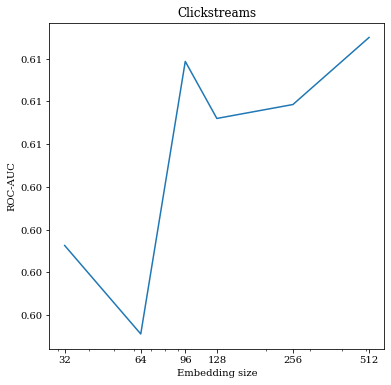

In [33]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.ticker import StrMethodFormatter

fig = plt.figure(figsize=(6,6))

plt.title('Clickstreams',fontfamily='serif')
plt.xlabel('Embedding size',fontfamily='serif')
plt.plot(embed_sizes,roc_auc_list)
plt.ylabel('ROC-AUC',fontfamily='serif')
plt.xscale('log')
plt.xticks(embed_sizes,fontfamily='serif')
plt.yticks(fontfamily='serif')
fig.axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))


plt.show()